In [42]:
import pandas as pd
stock_data= pd.read_csv("/content/RELIANCE.NS.csv", index_col= 'Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1503.745972,1512.760498,1491.363403,1495.424927,1480.595825,6463060
2020-01-02,1497.802368,1526.480469,1497.802368,1520.883545,1505.802002,8173308
2020-01-03,1518.605103,1527.173950,1508.699097,1522.716187,1507.616455,9684434
2020-01-06,1505.727173,1513.552979,1483.933838,1487.400879,1472.651367,11315596
2020-01-07,1504.736572,1520.091064,1499.288208,1510.284058,1495.307617,7699489


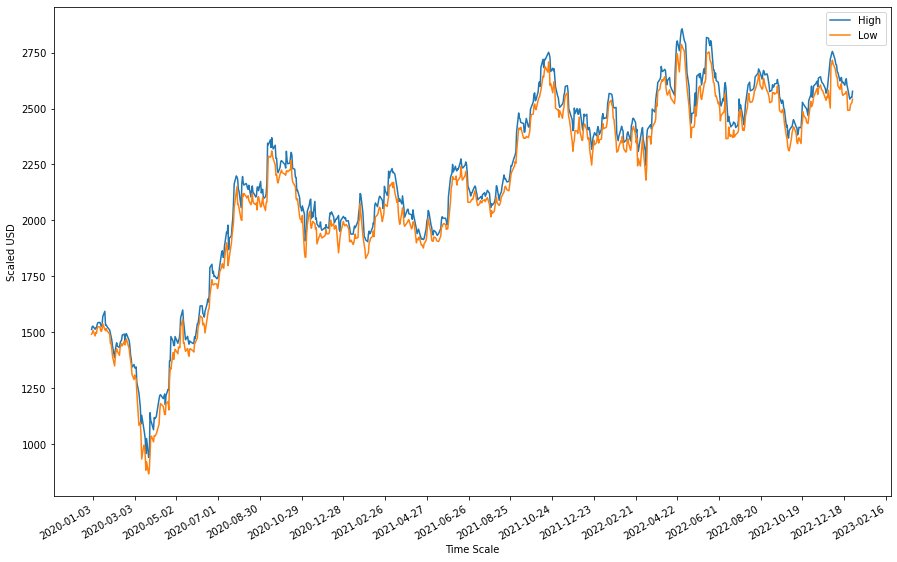

In [43]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

x_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data.index.values]
plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend ()
plt.gcf().autofmt_xdate()
plt.show()

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit


In [45]:
target_y= stock_data['Close']
X_feat= stock_data.iloc[:,0:3]

In [46]:
sc= StandardScaler()
X_ft= sc.fit_transform(X_feat.values)
X_ft= pd.DataFrame(columns= X_feat.columns, data=X_ft, index= X_feat.index)
X_ft.head()

,Open,High,Low
Date,,,
2020-01-01,-1.572950,-1.610758,-1.540494
2020-01-02,-1.587276,-1.577736,-1.524953
2020-01-03,-1.537137,-1.576067,-1.498653
2020-01-06,-1.568175,-1.608851,-1.558425
2020-01-07,-1.570563,-1.593114,-1.521367


In [47]:
def lstm_split(data,n_steps):
  X,y= [],[]
  for i in range(len(data)-n_steps+1):
    X.append(data[i:i+n_steps,:-1])
    y.append(data[i+n_steps-1,-1])
  return np.array(X), np.array(y)


In [48]:
X1, y1= lstm_split(X_ft.values, n_steps=2)
#print(X1[:5])
train_split= 0.8
split_idx= int(np.ceil(len(X1)*train_split))
date_index= X_ft.index

X_train, X_test= X1[:split_idx],X1[split_idx:]
y_train, y_test= y1[:split_idx],y1[split_idx:]
X_train_date, X_test_date= date_index[:split_idx], date_index[split_idx:] 
print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(746, 2, 2) (597, 2, 2) (149, 2, 2) (149,)


In [49]:
lstm= Sequential()
lstm.add(LSTM(32, input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer= 'adam')
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4480      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [50]:
history= lstm.fit(X_train, y_train, epochs= 10, batch_size= 4, verbose=2, shuffle=False)

Epoch 1/10
150/150 - 2s - loss: 0.7883 - 2s/epoch - 12ms/step
Epoch 2/10
150/150 - 0s - loss: 0.3097 - 309ms/epoch - 2ms/step
Epoch 3/10
150/150 - 0s - loss: 0.0086 - 409ms/epoch - 3ms/step
Epoch 4/10
150/150 - 0s - loss: 0.0088 - 349ms/epoch - 2ms/step
Epoch 5/10
150/150 - 0s - loss: 0.0082 - 382ms/epoch - 3ms/step
Epoch 6/10
150/150 - 0s - loss: 0.0076 - 370ms/epoch - 2ms/step
Epoch 7/10
150/150 - 0s - loss: 0.0070 - 431ms/epoch - 3ms/step
Epoch 8/10
150/150 - 0s - loss: 0.0065 - 404ms/epoch - 3ms/step
Epoch 9/10
150/150 - 0s - loss: 0.0060 - 342ms/epoch - 2ms/step
Epoch 10/10
150/150 - 0s - loss: 0.0056 - 336ms/epoch - 2ms/step


In [51]:
y_pred= lstm.predict(X_test)
rmse= mean_squared_error(y_test, y_pred, squared=False)
mape= mean_absolute_percentage_error(y_test, y_pred)
print("RSME:", rmse)
print("MAPE:",mape)

5/5 [==============================] - 0s 3ms/step
RSME: 0.0850904076779895
MAPE: 0.07611384107876784
